# Theory

In this notebook, we will model COVID-19 dynamics with the SIR model. It segments the population into three compartments:
1. Susceptible: # people vulnerable to exposure with the infectious
2. Infectious: # people who can spread the disease
3. Recovered: # people who were infected and is now healed with immunity.

The SIR model is described by the ODE

$$\begin{split} \dot{S}  & = - \beta I S \\
\dot{I} & = \beta I S - \gamma I \\
\dot{R} & = \gamma I
\end{split}$$

Remark: the outstanding period of the disease is assumed to be much shorter than the lifetime of human (hence natural deaths/births are not considered). The two parameters $\beta$ (how much the disease can be transmitted through exposure) and $\gamma$ (how much the disease can be recovered) can be used to derive the **average days to recover from the disease** as 

$$ D = \frac{1}{\gamma} $$

and the **basic reproduction number** (the average number of people than a sick person can infect)

$$ R_0 = \frac{\beta}{\gamma} $$

For more details, see https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology

## Controlling a pandemic

Naturally, the higher $R_0$ is, the higher number of people with immunity is required to avoid a pandemic. We define the **balanced state** as follows: If the proportion of people with immunity is $p$, the basic reproduction number multiplied by the proportion of people without immunity is one

$$ R_0 (1-p) = 1 $$

leading to $p_c = 1 - \frac{1}{R_0}$ as the minimum **Herd Immune Threshold** to stop a pandemic. HIT can be increased, for example, by vaccination.

## Visualizations

* https://meltingasphalt.com/interactive/outbreak/

In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import scipy
import matplotlib.pyplot as plt

In [11]:
def f(x, t, beta, gamma, population):
    """
    The system of ODEs for the SIR model
    
    Args:
    x -- a list consisting of S, I, and R in order
    """
    r1 = -beta * x[0] * x[1] / population
    r2 = beta * x[0] * x[1] / population - gamma * x[1]
    r3 = gamma * x[1]
    return [r1, r2, r3]

In [3]:
# data is from Kaggle COVID-19 Forecasting Challenge
# which is curated from John Hopkins CSSE
# https://github.com/CSSEGISandData/COVID-19

pop_italy = 60486683.
pop_spain = 46749696.
pop_UK = 67784927.
pop_singapore = 5837230.

train_data = pd.read_csv("train.csv")

display(train_data)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
22333,32704,NaN,Zimbabwe,2020-03-30,7.0,1.0
22334,32705,NaN,Zimbabwe,2020-03-31,8.0,1.0
22335,32706,NaN,Zimbabwe,2020-04-01,8.0,1.0
22336,32707,NaN,Zimbabwe,2020-04-02,9.0,1.0


In [13]:
# first we prepare the data into a form that is suitable for analysis
country = 'Spain'
population = pop_spain

country_df = train_data.copy()
country_df = country_df.loc[country_df['Country_Region']==country]
country_df['ConfirmedDiff'] = country_df.ConfirmedCases.diff().fillna(0) # need daily cases instead of cumulative cases

first_occurence = country_df.ConfirmedCases.to_numpy().nonzero()[0][0]

# now we need the day count since the first occurence
country_df = country_df[first_occurence:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases] #infected cases
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

# initial conditions
# we start with 0 recovered case
x0 = [population - ydata[0], ydata[0], 0.]

# testing to see if you get it right
temp = odeint(f, x0, xdata, args=(0.3, 0.5, population))
temp[:,1] # the infected cases


array([1.00000000e+00, 8.18730748e-01, 6.70320042e-01, 5.48811637e-01,
       4.49328948e-01, 3.67879421e-01, 3.01194191e-01, 2.46596938e-01,
       2.01896491e-01, 1.65298859e-01, 1.35335255e-01, 1.10803131e-01,
       9.07179257e-02, 7.42735606e-02, 6.08100498e-02, 4.97870575e-02,
       4.07621946e-02, 3.33732621e-02, 2.73237159e-02, 2.23707670e-02,
       1.83156351e-02, 1.49955738e-02, 1.22773376e-02, 1.00518339e-02,
       8.22974561e-03, 6.73794587e-03, 5.51656351e-03, 4.51658025e-03,
       3.69786315e-03, 3.02755432e-03, 2.47875234e-03, 2.02943065e-03,
       1.66155654e-03, 1.36036691e-03, 1.11377394e-03, 9.11880722e-04,
       7.46584575e-04, 6.11251594e-04, 5.00449872e-04, 4.09733599e-04,
       3.35461496e-04, 2.74652552e-04, 2.24866354e-04, 1.84104956e-04,
       1.50732343e-04, 1.23409172e-04, 1.01038791e-04, 8.27230444e-05,
       6.77283689e-05, 5.54518686e-05, 4.54009735e-05, 3.71711259e-05,
       3.04330755e-05, 2.49166668e-05, 2.04000022e-05, 1.67021324e-05,
      

In [14]:
# fit the parameters beta and gamma from data
# using least squares fit
p_opt, p_cov = scipy.optimize.curve_fit(lambda t, beta, gamma: odeint(f, x0, t, args=(beta, gamma,population))[:,1], xdata, ydata)
p_opt

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


array([2.98538476, 2.77751042])

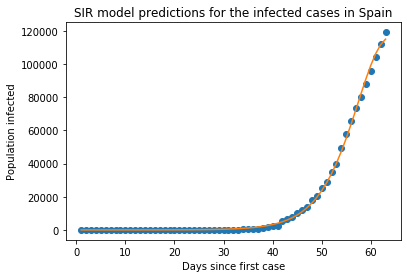

Fitted parameters: beta = 2.985384764646714  and gamma =  2.7775104204384014


In [15]:
pred_data = odeint(f, x0, xdata, args=(p_opt[0], p_opt[1],population))[:,1]

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, pred_data)
plt.title("SIR model predictions for the infected cases in " + country)
plt.ylabel("Population infected")
plt.xlabel("Days since first case")
plt.show()
print("Fitted parameters: beta =", p_opt[0], " and gamma = ", p_opt[1])

In [19]:
print("Average day to recover from disease in ", country, " is ", 1/p_opt[1])
print("Basic reproduction number in ", country, " is ", p_opt[0]/p_opt[1])

Average day to recover from disease in  Spain  is  0.3600346528464726
Basic reproduction number in  Spain  is  1.074841967352728
